In [2]:
using PyPlot
using CPUTime

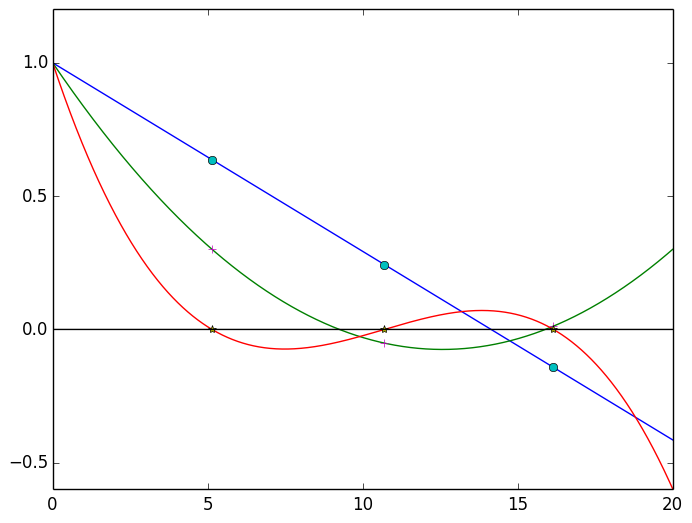

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at /Applications/Julia-0.4.6.app/Contents/Resources/julia/lib/julia/sys.dylib
 in vect at abstractarray.jl:32
 in include_string at loading.jl:282
 in execute_request at /Users/michaelwathen/.julia/v0.4/IJulia/src/execute_request.jl:151
 in eventloop at /Users/michaelwathen/.julia/v0.4/IJulia/src/eventloop.jl:8
 in anonymous at task.jl:447
while loading In[3], in expression starting on line 26


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31fee3ad0>

In [3]:
# small 3 x 3 problem
A=[7 3 1; 3 10 2; 1 2 15];
b=Array([28 31 22])';

eigA, vecA=eig(A);
r0=b; p0=b;
delta0=norm(r0)^2;
s0=A*p0;
alpha0=delta0/(p0'*s0)[1];
x1=zeros(3,1)+alpha0*p0;
r1=b-alpha0*s0;
delta1=norm(r1)^2;
p1=r1+delta1/delta0*p0;
s1=A*p1;
alpha1=delta1/(p1'*s1)[1];
x2=x1+alpha1*p1;

r2=r1-alpha1*s1;
delta2=norm(r2)^2;
p2=r2+delta2/delta1*p1;
s2=A*p2;
alpha2=delta2/(p2'*s2)[1]
x3=x2+alpha2*p2


x=[0:.01:20];

# p1:
c10=1;
c11=-alpha0;
p1=c10+c11*x;

# p2:
c20 = 1                                      # const (always 1)
c21 = -(alpha0+alpha1+alpha1*delta1/delta0)  # coef of x
c22 = alpha0*alpha1                          # coef of x^2
p2=c20+c21*x+c22*x.^2;

# p3:
c30 = 1;
c31 = -alpha0-alpha1*(1+delta1/delta0)-alpha2*(1+delta2/delta0+delta2/delta1);
c32 = alpha0*alpha1+alpha2*(alpha0+alpha1+alpha1*delta1/delta0)+alpha0*alpha2*delta2/delta1;
c33=-alpha0*alpha1*alpha2    # should be equal to: -1/(-eigA(1)*eigA(2)*eigA(3));
p3=c30+c31*x+c32*x.^2+c33*x.^3;
# Can also do this and then we are sure we're OK...
p33=(x-eigA[1]).*(x-eigA[2]).*(x-eigA[3])#/(-eigA[1]*eigA[2]*eigA[3]);

xx=eigA;
p1_eig=c10+c11*xx;
p2_eig=c20+c21*xx+c22*xx.^2;
p3_eig=c30+c31*xx+c32*xx.^2+c33*xx.^3;

plot(x,p1);
plot(x,p2);
plot(x,p3)
plot(xx,p1_eig,"o")
plot(xx,p2_eig,"+")
plot(xx,p3_eig,"*")
plot(x, 0*x, "k")

In [27]:
# Example 7.17 Figure 7.11 : Poisson on a square using CG, PCG/IC(tol) and multigrid.
# try a few grids and watch iteration count and timing

function Laplacian(N)
    x1 = ones(N)
    x2 = ones(N-1)
    D = spdiagm(x1, 0) -  spdiagm(x2, -1, N, N)
    Ax = D' * D
    Ay = D' * D
    return kron(speye(N), Ax) + kron(Ay, speye(N))
end

function poismg(A,b,x,level)

    # function [x,res] = poismg(A,b,x,level)

    # multigrid V-cycle to solve simplest Poisson on a square
    # The uniform grid is N by N, N = 2^l-1 some l > 2,
    # b is the right hand side; homogeneous Dirichlet;
    # A has been created by   A = delsq(numgrid('S',N+2));

    # coarsest = 3;              % coarsest grid
    # nu1 = 2;                   % relaxations before coarsening grid
    # nu2 = 2;                   % relaxations after return to finer level
    # omeg = .8;                 % relaxation damping parameter
    coarsest = 1;
    if level == coarsest
        x = A\b;               # solve exactly on coarsest level
        r = b - A*x;

    else # begin multigrid cycle

        # relax using damped Jacobi
        Dv = diag(A);         # diagonal part of A as vector
        for i=1:nu1
          r = b - A*x;
          x = x + omeg*r./Dv;
        end

        # restrict residual from r to rc on coarser grid
        r = b - A*x; 
        N = sqrt(length(b));
        r = reshape(r,N,N);
        Nc = (N+1)/2 - 1; nc = Nc^2;    # coarser grid dimensions
        Ac = Laplacian(Nc);  # coarser grid operator
            rc = r[2:2:N-1,2:2:N-1] + .5*(r[3:2:N,2:2:N-1] + r[1:2:N-2,2:2:N-1] + 
            r[2:2:N-1,3:2:N]+r[2:2:N-1,1:2:N-2]) + .25*(r[3:2:N,3:2:N] + 
            r[3:2:N,1:2:N-2]+r[1:2:N-2,3:2:N]+r[1:2:N-2,1:2:N-2]);
        rc = reshape(rc,nc,1);

        # descend level. Use V-cycle
        vc = zeros(size(rc));            # initialize correction to 0
        println(vc)
#         [vc,r] = poismg(Ac,rc,vc,level-1); # samesame on coarser grid

#         # prolongate correction from vc to v on finer grid
#         v = zeros(N,N);
#         vc = reshape(vc,Nc,Nc);
#         v(2:2:N-1,2:2:N-1) = vc;
#         vz = [zeros(1,N);v;zeros(1,N)];   # embed v with a ring of 0s
#         vz = [zeros(N+2,1),vz,zeros(N+2,1)];
#         v[1:2:N,2:2:N-1] = .5*(vz[1:2:N,3:2:N]+vz[3:2:N+2,3:2:N]);
#         v[2:2:N-1,1:2:N] = .5*(vz[3:2:N,1:2:N]+vz[3:2:N,3:2:N+2]);
#         v[1:2:N,1:2:N] = .25*(vz[1:2:N,1:2:N]+vz[1:2:N,3:2:N+2] + 
#         vz[3:2:N+2,3:2:N+2]+vz[3:2:N+2,1:2:N]);

#         # add to current solution
#         n = N^2;
#         x = x + reshape(v,n,1);

#         # relax using damped Jacobi
#         for i=1:nu2
#           r = b - A*x;
#           x = x + omeg*r./Dv;
#         end

    end
    res = norm(b - A*x);
    return [x, res];
end

Ns = zeros(5) 
time = zeros(4,5)
for l = 5:9
    N = 2^l - 1;
    Ns[l-4] = N;  # save for plotting
    tol = 1.e-6;  # should actually depend on N but never mind.
    
    A = Laplacian(N)
    n = size(A,1);
    b = A*ones(n);
    coarsest = 1;

    # Solve using multigrid
#     tic()
#     CPUtic();
    xmg = zeros(n); bb = norm(b);
    flevel = log2(N+1);
    rmg = zeros(100)
    println(size(b))
    for itermg = 1:100
        poismg(A,b,xmg,flevel);
        println(xmg);
        if rmg[itermg]/bb < tol
            break
        end
    end
#     time[1,l-4] = toq() - CPUtoq(); 

#     time(1,l-4) = cputime - t0;
#     itns(1,l-4) = itermg; 

#     # CG straight
#     t0 = cputime;
#     [xCG,flagCG,relresCG,iterCG,rCG] = pcg(A,b,tol,2000);
#     time(2,l-4) = cputime - t0;
#     itns(2,l-4) = iterCG;

#     # preconditioned CG with incomplete Cholesky
#     t0 = cputime;
#     R=cholinc(A,.01);
#     [xCGpc,flagCGpc,relresCGpc,iterCGpc,rCGpc] = pcg(A,b,tol,2000,R',R);
#     time(3,l-4) = cputime - t0;
#     itns(3,l-4) = iterCGpc;

#     # preconditioned CG with V-cycle
#     t0 = cputime;
#     x0 = zeros(n);
#     [xcgmg,itercgmg,rcgmg] = pcgmg(A,b,x0,tol);
#     time(4,l-4) = cputime - t0;
#     itns(4,l-4) = itercgmg;

#     figure(l-4)
#     semilogy(rCG/norm(b),"r-.")
#     semilogy(rCGpc/norm(b),"m")
#     semilogy(rcgmg/norm(b),"g--")
#     semilogy(rmg/norm(b),"b")
#     legend("CG","PCG/ICT(.01)","PCG/MG","MG")
#     xlabel("Iterations")
#     ylabel("Residuals")
  
end

# # Plot relative residuals  
# figure(10)
# plot(Ns,itns(2,:),"r-.")
# plot(Ns,itns(3,:),"m")
# plot(Ns,itns(4,:),"g--")
# plot(Ns,itns(1,:),"b")

# legend("CG","PCG/ICT(.01)","PCG/MG","MG")
# ylabel("Iterations")
# xlabel("N")

# figure(11)
# plot(Ns,time(2,:),"r-.")
# plot(Ns,time(3,:),"m")
# plot(Ns,time(4,:),"g--")
# plot(Ns,time(1,:),"b")
# legend("CG","PCG/ICT(.01)","PCG/MG",'MG")
# ylabel("CPU secs")
# xlabel("N")

(961,)


LoadError: LoadError: UndefVarError: nu1 not defined
while loading In[27], in expression starting on line 84

In [1]:
# Figures 7.5 and 7.7 : comparison of methods for Poisson model problems

function Laplacian(N)
    x1 = ones(N)
    x2 = ones(N-1)
    D = spdiagm(x1, 0) -  spdiagm(x2, -1, N, N)
    Ax = D' * D
    Ay = D' * D
    return kron(speye(N), Ax) + kron(Ay, speye(N))
end

N = 31;
tol = 1.e-6;

# build linear system
A = Laplacian(N)
n = size(A,1);
b = A*ones(n);

# Example 7.10, Figure 7.5

Dv = diag(A);         # diagonal part of A as vector
D = spdiagm(Dv);         # diagonal part of A as matrix
E = tril(A);          # lower triangular part of A
omega = 1+cos(pi/(N+1))/(1+sin(pi/(N+1)))^2; # for SOR
Eomega = ((1-omega)*D + omega*E)/omega;      # for SOR
# Jacobi
rJ = zeros(10000); x = zeros(n); r = b;
xNew = zeros(n);
println(size(A*x), size(b))
for i=1:1,
    x = x + r./Dv;
    println(xNew)

    r = b - A*xNew;
    rJ[i]=norm(r)/norm(b);
    if rJ[i] < tol
        break
    end
    x = xNew
end
xJ = x;

# # Gauss Seidel
# x = zeros(n); r = b;
# for i=1:10000,
#   x = x + E \ r;
#   r = b - A*x;
#   rGS(i) = norm(r)/norm(b);
#   if rGS(i) < tol,  break, end
# end
# xGS = x;

# # SOR
# x = zeros(n,1); r = b;
# for i=1:10000,    
#   x = x + Eomega \ r;
#   r = b - A*x;
#   rSOR(i) = norm(r)/norm(b);
#   if rSOR(i) < tol, break, end
# end
# xSOR = x;

# # Example 7.11, Figure 7.7

# # Conjugate gradient, using Matlab's builtin routines
# cpu0 = cputime;
# # CG
# [xCG,flagCG,relresCG,iterCG,rCG] = pcg(A,b,tol,2000);
# cgtime = cputime - cpu0 

# # preconditioned CG with incomplete Cholesky IC(0)
# R=cholinc(A,'0');
# [xCGpc,flagCGpc,relresCGpc,iterCGpc,rCGpc] = pcg(A,b,tol,2000,R',R);
# cgic0time = cputime - (cpu0+cgtime)

# # preconditioned CG with incomplete Cholesky IC(0.01)
# R=cholinc(A,.01);
# [xCGpct,flagCGpct,relresCGpct,iterCGpct,rCGpct] = pcg(A,b,tol,2000,R',R);
# cgictoltime = cputime - (cpu0+cgtime+cgic0time)

# # Plot relative residuals
# figure(1)
# semilogy(rJ,'m')
# hold on
# semilogy(rGS,'r-.')
# semilogy(rSOR,'--')
# legend('Jacobi','Gauss-Seidel','SOR')
# xlabel('Iterations')
# ylabel('Residual norm')

# figure(2)
# semilogy(rCG/norm(b),'m')
# hold on
# semilogy(rCGpc/norm(b),'r-.')
# semilogy(rCGpct/norm(b),'b--')
# legend('CG','PCG/IC(0)','PCG/IC(.01)')
# xlabel('Iterations')
# ylabel('Residual norm')

(961,)(961,)
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

961-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0